# Fit halo mass to shear profile: 2. realistic data and wrong model

_the LSST-DESC CLMM team_


This notebook demonstrates how to use `clmm` to estimate a WL halo mass from observations of a galaxy cluster. It uses several functionalities of the support `mock_data` module to produce datasets of increasing complexity. This notebook also demonstrates the bias introduced on the reconstructed mass by a naive fit, when the redshift distribution of the background galaxies is not properly accounted for in the model. Organization of this notebook goes as follows:

- Setting things up, with the proper imports.
- Generating 3 datasets: an ideal dataset (dataset1) similar to that of Example1 (single source plane); an ideal dataset but with source galaxies following the Chang et al. (2013) redshift distribution (dataset2); a noisy dataset where photoz errors and shape noise are also included (dataset3). 
- Computing the binned reduced tangential shear profile, for the 3 datasets, using logarithmic binning.
- Setting up the "single source plane" model to be fitted to the 3 datasets. Only dataset1 has a single source plane, so we expect to see a bias in the reconstructed mass when using this model on datasets 2 and 3. 
- Perform a simple fit using `scipy.optimize.curve_fit` and visualize the results.

## Setup

First, we import some standard packages.

In [1]:
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
from clmm.support.sampler import fitters

clmm.__version__

'0.9.0'

Next, we import `clmm`'s core modules.

In [2]:
import clmm.dataops as da
import clmm.galaxycluster as gc
import clmm.theory as theory
from clmm import Cosmology

We then import a support modules for a specific data sets.
`clmm` includes support modules that enable the user to generate mock data in a format compatible with `clmm`.

In [3]:
from clmm.support import mock_data as mock

## Making mock data

For reproducibility:

In [4]:
np.random.seed(11)

To create mock data, we need to define a true cosmology.

In [5]:
mock_cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

We now set some parameters for a mock galaxy cluster.

In [6]:
cosmo = mock_cosmo
cluster_m = 1.e15 # M200,m [Msun]
cluster_z = 0.3
concentration = 4
ngals = 10000
Delta = 200
cluster_ra = 0.0
cluster_dec = 0.0

Then we use the `mock_data` support module to generate 3 galaxy catalogs:
- `ideal_data`: all background galaxies at the same redshift.
- `ideal_data_z`: galaxies distributed according to the Chang et al. (2013) redshift distribution.
- `noisy_data_z`: `ideal_data_z` + photoz errors + shape noise

In [7]:
ideal_data = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, 0.8, ngals=ngals)
ideal_data_z = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo,'chang13', ngals=ngals)
noisy_data_z = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, 'chang13', 
                                            shapenoise=0.05, 
                                            photoz_sigma_unscaled=0.05, ngals=ngals)

/Users/combet/anaconda3/envs/clmmenv/lib/python3.8/site-packages/numpy/ma/core.py:2831: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/combet/anaconda3/envs/clmmenv/lib/python3.8/site-packages/clmm-0.9.0-py3.8.egg/clmm/cosmology/cluster_toolkit.py:69: UserWarning: Some source redshifts are lower than the cluster redshift. Returning Sigma_crit = np.inf for those galaxies.
/Users/combet/anaconda3/envs/clmmenv/lib/python3.8/site-packages/clmm-0.9.0-py3.8.egg/clmm/cosmology/cluster_toolkit.py:79: RuntimeWarning: divide by zero encountered in true_divide
/Users/combet/anaconda3/envs/clmmenv/lib/python3.8/site-packages/clmm-0.9.0-py3.8.egg/clmm/theory/func_layer.py:354: UserWarning: Some source redshifts are lower than the

The galaxy catalogs are converted to a `clmm.GalaxyCluster` object and may be saved for later use.

In [8]:
cluster_id = "CL_ideal"
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                               cluster_z, ideal_data)
gc_object.save('ideal_GC.pkl')

cluster_id = "CL_ideal_z"
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                               cluster_z, ideal_data_z)
gc_object.save('ideal_GC_z.pkl')

cluster_id = "CL_noisy_z"
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                               cluster_z, noisy_data_z)
gc_object.save('noisy_GC_z.pkl')

Any saved `clmm.GalaxyCluster` object may be read in for analysis.

In [9]:
cl1 = clmm.GalaxyCluster.load('ideal_GC.pkl') # all background galaxies at the same redshift
cl2 = clmm.GalaxyCluster.load('ideal_GC_z.pkl') # background galaxies distributed according to Chang et al. (2013)
cl3 = clmm.GalaxyCluster.load('noisy_GC_z.pkl') # same as cl2 but with photoz error and shape noise

print("Cluster info = ID:", cl2.unique_id, "; ra:", cl2.ra, "; dec:", cl2.dec, "; z_l :", cl2.z)
print("The number of source galaxies is :", len(cl2.galcat))

Cluster info = ID: CL_ideal_z ; ra: 0.0 ; dec: 0.0 ; z_l : 0.3
The number of source galaxies is : 10000


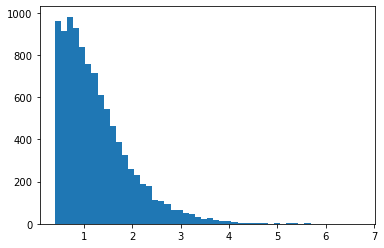

In [10]:
h = plt.hist(cl2.galcat['z'], bins=50)

## Deriving observables

### Computing shear

`clmm.dataops.compute_tangential_and_cross_components` calculates the tangential and cross shears for each source galaxy in the cluster.

In [11]:
theta1, g_t1, g_x1 = cl1.compute_tangential_and_cross_components(geometry="flat")
theta2, g_t2, g_x2 = cl2.compute_tangential_and_cross_components(geometry="flat")
theta2, g_t3, g_x3 = cl3.compute_tangential_and_cross_components(geometry="flat")

### Radially binning the data

In [12]:
bin_edges = da.make_bins(0.7, 4, 15, method='evenlog10width')

`clmm.dataops.make_radial_profile` evaluates the average shear of the galaxy catalog in bins of radius.

In [13]:
profile1 = cl1.make_radial_profile("Mpc", bins=bin_edges,cosmo=cosmo)
profile2 = cl2.make_radial_profile("Mpc", bins=bin_edges,cosmo=cosmo)
profile3 = cl3.make_radial_profile("Mpc", bins=bin_edges,cosmo=cosmo)

After running `clmm.dataops.make_radial_profile` on a `clmm.GalaxyCluster` object, the object acquires the `clmm.GalaxyCluster.profile` attribute.

In [14]:
for n in cl1.profile.colnames: cl1.profile[n].format = "%6.3e"
cl1.profile.pprint(max_width=-1)

radius_min   radius  radius_max     gt      gt_err      gx       gx_err      z       z_err     n_src  
---------- --------- ---------- --------- --------- ---------- --------- --------- --------- ---------
 7.000e-01 7.446e-01  7.863e-01 4.353e-02 1.310e-04  1.437e-18 5.554e-19 8.000e-01 2.916e-17 5.800e+01
 7.863e-01 8.403e-01  8.831e-01 3.984e-02 1.099e-04  2.168e-19 5.768e-19 8.000e-01 2.394e-17 8.600e+01
 8.831e-01 9.395e-01  9.920e-01 3.654e-02 1.001e-04 -4.497e-19 6.185e-19 8.000e-01 3.417e-17 9.500e+01
 9.920e-01 1.052e+00  1.114e+00 3.332e-02 8.489e-05 -3.593e-19 4.184e-19 8.000e-01 1.933e-17 1.320e+02
 1.114e+00 1.187e+00  1.251e+00 3.003e-02 7.147e-05 -4.786e-19 3.937e-19 8.000e-01 1.807e-17 1.510e+02
 1.251e+00 1.331e+00  1.406e+00 2.708e-02 6.600e-05  4.616e-19 3.754e-19 8.000e-01 1.718e-17 1.670e+02
 1.406e+00 1.495e+00  1.579e+00 2.426e-02 5.243e-05  4.622e-19 3.191e-19 8.000e-01 0.000e+00 2.350e+02
 1.579e+00 1.677e+00  1.773e+00 2.165e-02 3.908e-05 -1.391e-19 2.192e-19 

We visualize the radially binned shear for the 3 configurations

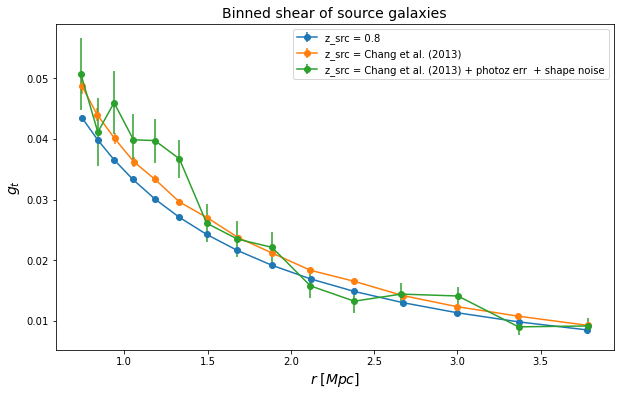

In [15]:
fig = plt.figure(figsize=(10, 6))


fsize = 14
fig.gca().errorbar(profile1['radius'], profile1['gt'], yerr=profile1['gt_err'], marker='o', label='z_src = 0.8')
fig.gca().errorbar(profile2['radius'], profile2['gt'], yerr=profile2['gt_err'], marker='o', 
                   label='z_src = Chang et al. (2013)')
fig.gca().errorbar(profile3['radius'], profile3['gt'], yerr=profile3['gt_err'], marker='o', 
                   label='z_src = Chang et al. (2013) + photoz err  + shape noise')

plt.gca().set_title(r'Binned shear of source galaxies', fontsize=fsize)
plt.gca().set_xlabel(r'$r\;[Mpc]$', fontsize=fsize)
plt.gca().set_ylabel(r'$g_t$', fontsize=fsize)
plt.legend()

## Create the halo model

`clmm.theory.predict_reduced_tangential_shear` supports various parametric halo profile functions, including `nfw`.
Beware that the `clmm.theory` module works in units of $Mpc/h$, whereas the data is cosmology-independent, with units of $Mpc$.

In [16]:
# model definition to be used with scipy.optimize.curve_fit
def shear_profile_model(r, logm, z_src):
    m = 10.**logm
    gt_model = clmm.compute_reduced_tangential_shear(r,
                                                     m, concentration,
                                                     cluster_z, z_src, cosmo,
                                                     delta_mdef=200,
                                                     halo_profile_model='nfw')    
    return gt_model

### Fitting a halo mass - highlighting bias when not accounting for the source redshift distribution in the model

We estimate the best-fit mass using `scipy.optimize.curve_fit`.

Here, to build the model we make the WRONG assumption that the average shear in bin $i$ equals the shear at the average redshift in the bin; i.e. we assume that $\langle g_t\rangle_i = g_t(\langle z\rangle_i)$. This should not impact `cluster 1` as all sources are located at the same redshift. However, this yields a bias in the reconstructed mass for `cluster 2` and `cluster 3`, where the sources followed the Chang et al. (2013) distribution.

In [17]:
# Cluster 1:  ideal data
popt1,pcov1 = fitters['curve_fit'](lambda r, logm:shear_profile_model(r, logm, profile1['z']), 
                    profile1['radius'], 
                    profile1['gt'], 
                    profile1['gt_err'], bounds=[13.,17.])
#popt1,pcov1 = spo.curve_fit(lambda r, logm:shear_profile_model(r, logm, profile1['z']), 
#                    profile1['radius'], 
#                    profile1['gt'], 
#                    sigma=profile1['gt_err'], bounds=[13.,17.])

m_est1 = 10.**popt1[0]
m_est_err1 =  m_est1 * np.sqrt(pcov1[0][0]) * np.log(10) # convert the error on logm to error on m

# Cluster 2:  ideal data with redshift distribution
popt2,pcov2 = fitters['curve_fit'](lambda r, logm:shear_profile_model(r, logm, profile2['z']), 
                    profile2['radius'], 
                    profile2['gt'], 
                    profile2['gt_err'], bounds=[13.,17.])

m_est2 = 10.**popt2[0]
m_est_err2 =  m_est2 * np.sqrt(pcov2[0][0]) * np.log(10) # convert the error on logm to error on m

# Cluster 3:  noisy data with redshift distribution
popt3,pcov3 = fitters['curve_fit'](lambda r, logm:shear_profile_model(r, logm, profile3['z']), 
                    profile3['radius'], 
                    profile3['gt'], 
                    profile3['gt_err'], bounds=[13.,17.])

m_est3 = 10.**popt3[0]
m_est_err3 =  m_est3 * np.sqrt(pcov3[0][0]) * np.log(10) # convert the error on logm to error on m



print(f'Best fit mass for cluster 1 = {m_est1:.2e} +/- {m_est_err1:.2e} Msun')
print(f'Best fit mass for cluster 2 = {m_est2:.2e} +/- {m_est_err2:.2e} Msun')
print(f'Best fit mass for cluster 3 = {m_est3:.2e} +/- {m_est_err3:.2e} Msun')

Best fit mass for cluster 1 = 1.00e+15 +/- 7.57e+10 Msun
Best fit mass for cluster 2 = 8.68e+14 +/- 2.62e+12 Msun
Best fit mass for cluster 3 = 8.87e+14 +/- 4.12e+13 Msun


As expected, the reconstructed mass is biased whenever the sources are not located at a single redshift as this was not accounted for in the model.

## Visualization of the results

For visualization purpose, we calculate the reduced tangential shear predicted by the model when using the average redshift of the catalog.

In [18]:
rr = np.logspace(-0.5, np.log10(5), 100)
gt_model1 = clmm.compute_reduced_tangential_shear(rr,
                                                  m_est1, concentration,
                                                  cluster_z, np.mean(cl1.galcat['z']), cosmo,
                                                  delta_mdef=200,
                                                  halo_profile_model='nfw')

gt_model2 = clmm.compute_reduced_tangential_shear(rr,
                                                  m_est2, concentration,
                                                  cluster_z, np.mean(cl2.galcat['z']), cosmo,
                                                  delta_mdef=200,
                                                  halo_profile_model='nfw')

gt_model3 = clmm.compute_reduced_tangential_shear(rr,
                                                  m_est3, concentration,
                                                  cluster_z, np.mean(cl3.galcat['z']), cosmo,
                                                  delta_mdef=200,
                                                  halo_profile_model='nfw')

We visualize that prediction of reduced tangential shear along with the data

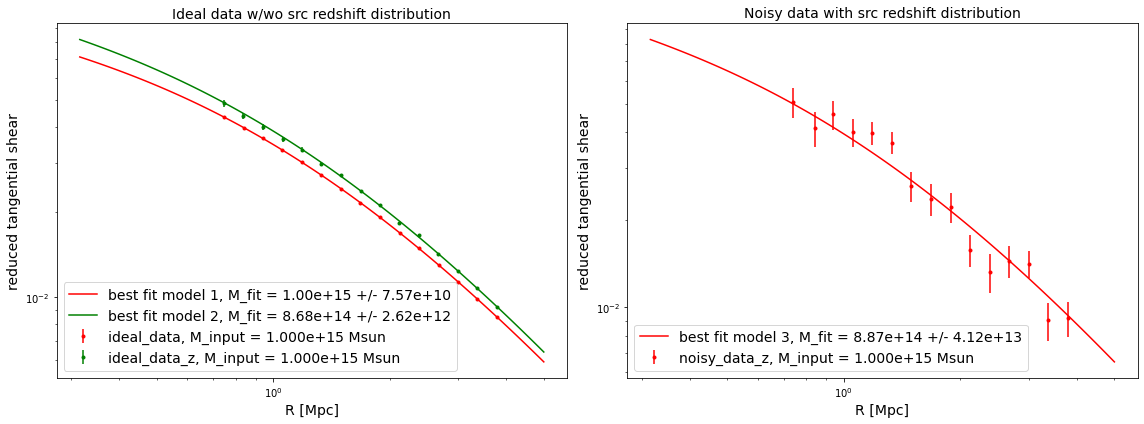

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

axes[0].errorbar(profile1['radius'], profile1['gt'],profile1['gt_err'], color='red',
                 label='ideal_data, M_input = %.3e Msun' % cluster_m, fmt='.')
axes[0].plot(rr, gt_model1,color='red',
             label='best fit model 1, M_fit = %.2e +/- %.2e' % (m_est1, m_est_err1))


axes[0].errorbar(profile2['radius'], profile2['gt'],profile2['gt_err'], color='green',
                  label='ideal_data_z, M_input = %.3e Msun' % cluster_m, fmt='.')
axes[0].plot(rr, gt_model2, color='green',
               label='best fit model 2, M_fit = %.2e +/- %.2e' % (m_est2, m_est_err2))
axes[0].set_title('Ideal data w/wo src redshift distribution',fontsize=fsize)
axes[0].semilogx()
axes[0].semilogy()
axes[0].legend(fontsize=fsize)
axes[0].set_xlabel('R [Mpc]', fontsize=fsize)
axes[0].set_ylabel('reduced tangential shear', fontsize=fsize)

axes[1].errorbar(profile3['radius'], profile3['gt'],profile3['gt_err'], color='red',
                label='noisy_data_z, M_input = %.3e Msun' % cluster_m, fmt='.')
axes[1].plot(rr, gt_model3,color='red',
             label='best fit model 3, M_fit = %.2e +/- %.2e' % (m_est3, m_est_err3))
axes[1].set_title('Noisy data with src redshift distribution',fontsize=fsize)
axes[1].semilogx()
axes[1].semilogy()
axes[1].legend(fontsize=fsize)
axes[1].set_xlabel('R [Mpc]', fontsize=fsize)
axes[1].set_ylabel('reduced tangential shear', fontsize=fsize)

fig.tight_layout()